Import packages

In [50]:
pip install networkx

     ---------------------------------------- 1.6/1.6 MB 5.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

Load data

In [39]:
df = pd.read_csv('elliptic_txs_features.csv', header=None)
df_edgelist = pd.read_csv('elliptic_txs_edgelist.csv')
df_classes = pd.read_csv('elliptic_txs_classes.csv')

## 1. Data cleaning

Rename columns

In [40]:
colNames1 = {'0': 'txId', 1: "Timestep"}
colNames2 = {str(i+2): "local" + str(i+1) for i in range(93)}
colNames3 = {str(i+95): "aggregated" + str(i+1) for i in range(72)}

colNames = dict(colNames1, **colNames2, **colNames3 )
colNames = {int(j): item_kk for j,item_kk in colNames.items()} 

df = df.rename(columns=colNames)

Rename unknown class and check shapes

In [41]:
df_classes.loc[df_classes['class'] == 'unknown', 'class'] = 3
print('Shape of classes', df_classes.shape)
print('Shape of edges', df_edgelist.shape)
print('Shape of features', df.shape)

Shape of classes (203769, 2)
Shape of edges (234355, 2)
Shape of features (203769, 167)


Check for missing values

In [42]:
# Function to calculate total missing values and percentage
def calculate_missing(df):
    total_missing = df.isna().sum().sum()
    total_cells = df.size
    percentage_missing = (total_missing / total_cells) * 100
    return total_missing, percentage_missing

# Check for missing values in the first DataFrame (df)
missing_values_df, percentage_missing_df = calculate_missing(df)
print("Missing values in df:")
print(f"Total: {missing_values_df}, Percentage: {percentage_missing_df:.2f}%")

# Check for missing values in the second DataFrame (df_edgelist)
missing_values_df_edgelist, percentage_missing_df_edgelist = calculate_missing(df_edgelist)
print("\nMissing values in df_edgelist:")
print(f"Total: {missing_values_df_edgelist}, Percentage: {percentage_missing_df_edgelist:.2f}%")

# Check for missing values in the third DataFrame (df_classes)
missing_values_df_classes, percentage_missing_df_classes = calculate_missing(df_classes)
print("\nMissing values in df_classes:")
print(f"Total: {missing_values_df_classes}, Percentage: {percentage_missing_df_classes:.2f}%")

Missing values in df:
Total: 0, Percentage: 0.00%

Missing values in df_edgelist:
Total: 0, Percentage: 0.00%

Missing values in df_classes:
Total: 0, Percentage: 0.00%


Merge the classes to the data

In [43]:
df = pd.merge(df, df_classes)

## 2. EDA

Plot of the distrbution of the classes

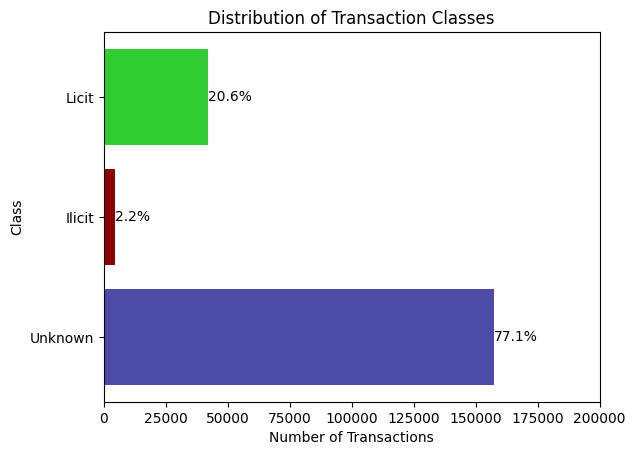

In [44]:
# Custom color palette
colors = [(0, 0, 0.5, 0.7), 'darkred', 'limegreen']

# Grouping by class and counting occurrences
group_class = df_classes.groupby('class').count()

# Calculate total transactions
total_transactions = group_class['txId'].sum()

# Calculate percentages
percentages = (group_class['txId'] / total_transactions) * 100

# Plotting
bars = plt.barh(['Unknown', 'Ilicit', 'Licit'], group_class['txId'].values, color=colors)

# Annotate percentages on bars
for bar, p, prc in zip(bars, group_class['txId'].values, percentages):
    plt.text(p, bar.get_y() + bar.get_height()/2, f'{prc:.1f}%', ha='left', va='center', fontsize=10)

# Adding labels and title
plt.xlabel('Number of Transactions')
plt.ylabel('Class')
plt.title('Distribution of Transaction Classes')

# Show plot
plt.xlim(0, 200000)
plt.show()

Plot of the transactions per timestep

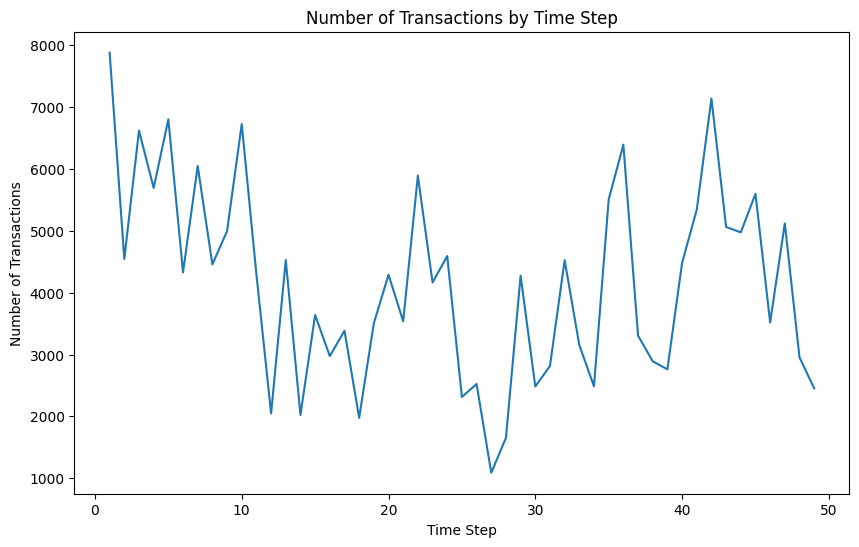

In [45]:
# Grouping by time step and counting occurrences
group_feature = df.groupby(df['Timestep']).count()

# Plotting
group_feature['txId'].plot(figsize=(10, 6))

# Adding labels and title
plt.title('Number of Transactions by Time Step')
plt.xlabel('Time Step')
plt.ylabel('Number of Transactions')

# Show plot
plt.show()

Plot of the transactions per timestep per class

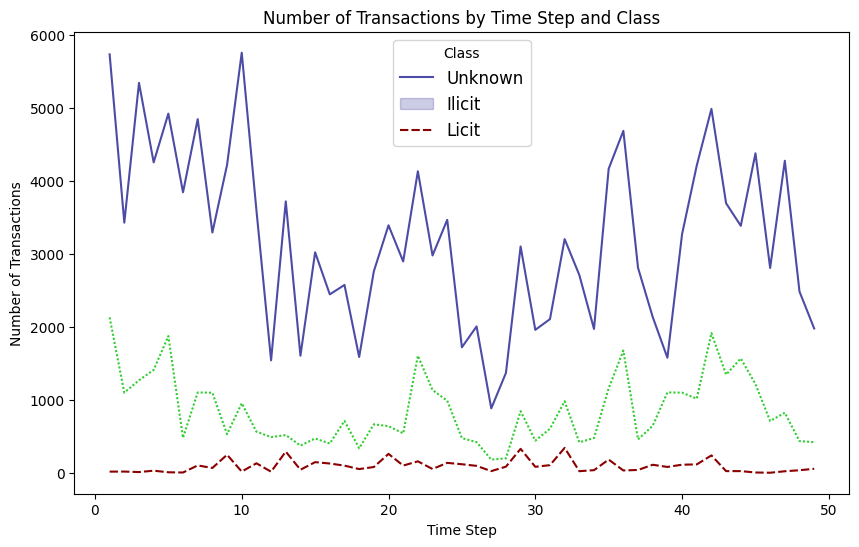

In [46]:
# Grouping by time step and counting occurrences for each class
grouped_df = df.groupby(['Timestep', 'class']).size().unstack(fill_value=0)

# Create figure and axes for line plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting line plot
sns.lineplot(data=grouped_df, palette=colors, ax=ax)

# Adding labels and title
plt.title('Number of Transactions by Time Step and Class')
plt.xlabel('Time Step')
plt.ylabel('Number of Transactions')

# Customize legend
plt.legend(['Unknown', 'Ilicit', 'Licit'], title='Class', fontsize=12)

# Show plot
plt.show()

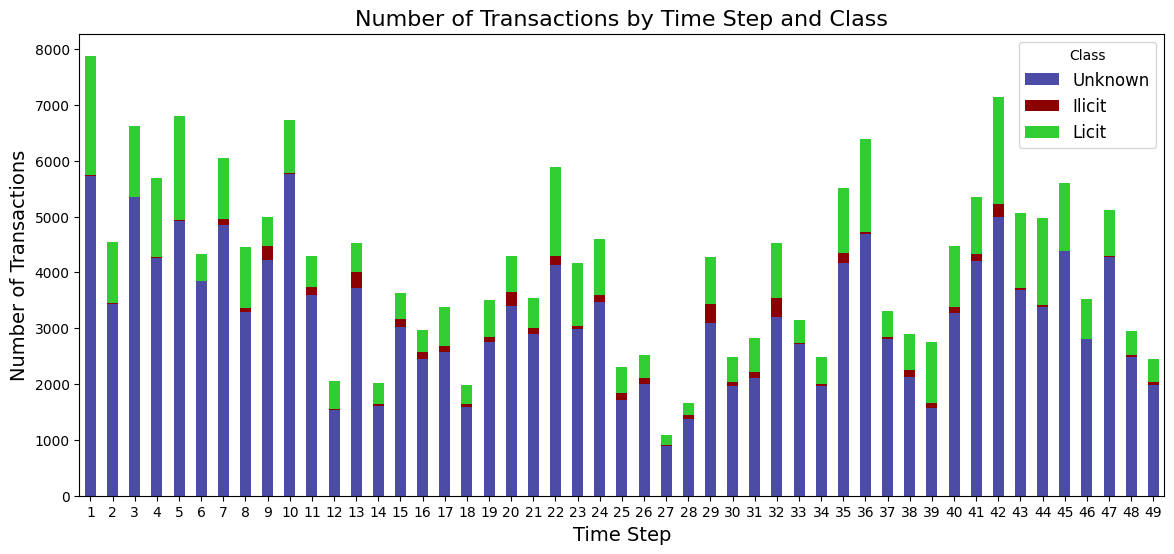

In [47]:
# Create figure and axes for bar plot
fig, ax = plt.subplots(figsize=(14, 6))

# Plotting bar plot
grouped_df.plot(kind='bar', stacked=True, color=colors, ax=ax)

# Adding labels and title
plt.title('Number of Transactions by Time Step and Class', fontsize=16)
plt.xlabel('Time Step', fontsize=14)
plt.ylabel('Number of Transactions', fontsize=14)
plt.xticks(rotation=0) 

# Customize legend
plt.legend(['Unknown', 'Ilicit', 'Licit'], title='Class', fontsize=12)

# Show plot
plt.show()


Find the most occuring ilicit counts per timestep

In [48]:
# Filter DataFrame for illicit transactions
illicit_df = df[df['class'] == '1']

# Group by time step and count occurrences
illicit_count = illicit_df.groupby('Timestep').size()

# Find the two time steps with the highest illicit transaction count
highest_counts = illicit_count.nlargest(3)

# Find the two time steps with the lowest illicit transaction count
lowest_counts = illicit_count.nsmallest(3)

print("Two time steps with the highest illicit transaction count:")
print(highest_counts)
print("\nTwo time steps with the lowest illicit transaction count:")
print(lowest_counts)


Two time steps with the highest illicit transaction count:
Timestep
32    342
29    329
13    291
dtype: int64

Two time steps with the lowest illicit transaction count:
Timestep
46    2
6     5
45    5
dtype: int64


Plot the ilicit transaction using the edgelist data

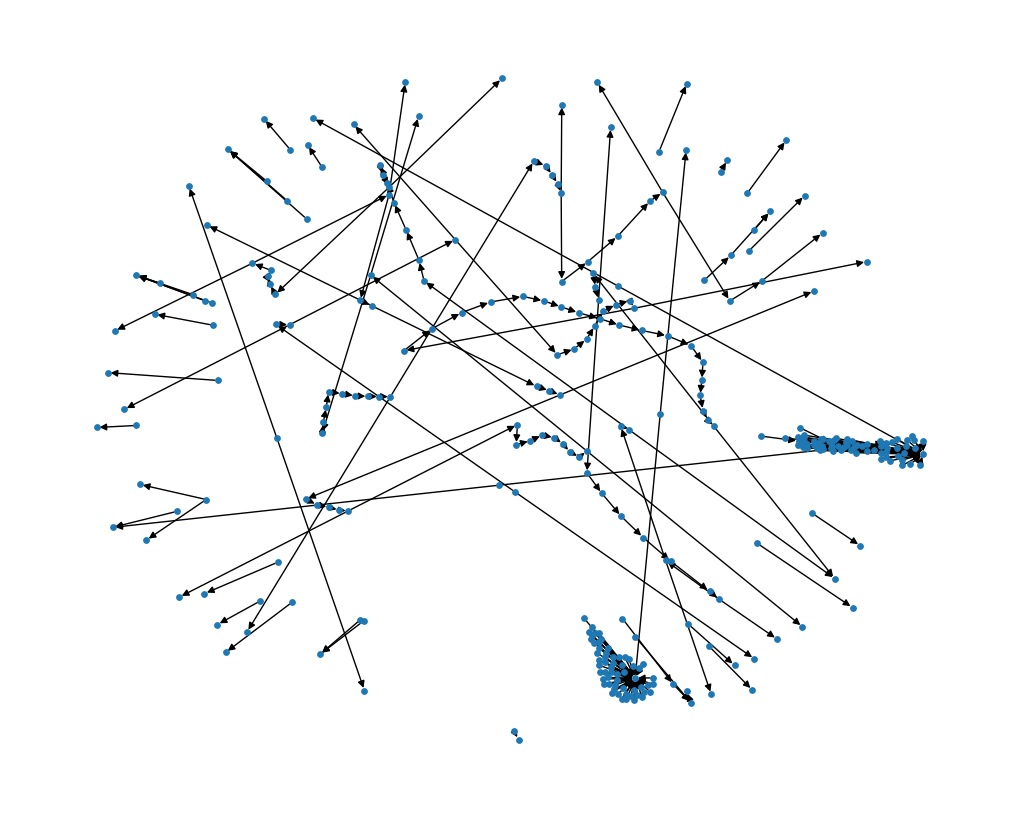

In [57]:
# Filter illicit transactions for time step 32
ilicit_ids = df.loc[(df['Timestep'] == 32) & (df['class'] == '1'), 'txId']
ilicit_edges = df_edgelist.loc[df_edgelist['txId1'].isin(ilicit_ids)]

# Create a directed graph from the DataFrame
graph = nx.from_pandas_edgelist(ilicit_edges, source='txId1', target='txId2', create_using=nx.DiGraph())

# Layout for the graph
pos = nx.spring_layout(graph)

# Set the figure size directly in NetworkX
plt.figure(figsize=(10, 8))

# Draw the graph with smaller node size
nx.draw(graph, with_labels=False, pos=pos, node_size=15)

# Show the plot
plt.show()

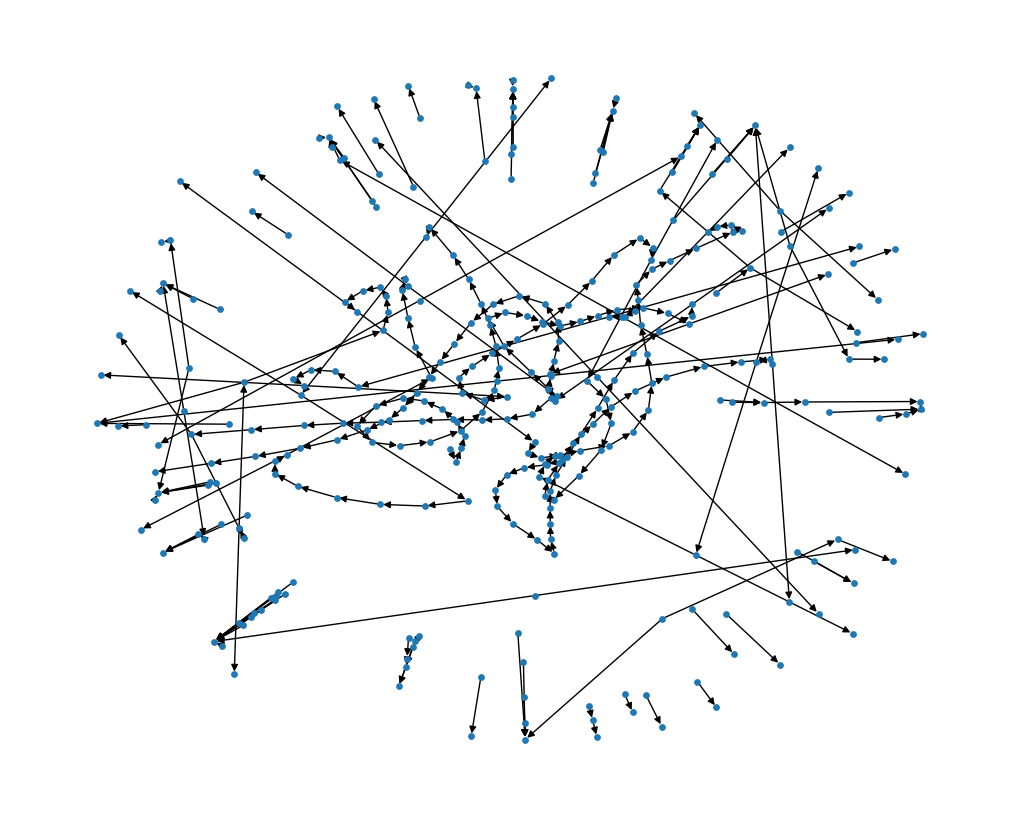

In [59]:
# Filter illicit transactions for time step 32
ilicit_ids = df.loc[(df['Timestep'] == 29) & (df['class'] == '1'), 'txId']
ilicit_edges = df_edgelist.loc[df_edgelist['txId1'].isin(ilicit_ids)]

# Create a directed graph from the DataFrame
graph = nx.from_pandas_edgelist(ilicit_edges, source='txId1', target='txId2', create_using=nx.DiGraph())

# Layout for the graph
pos = nx.spring_layout(graph)

# Set the figure size directly in NetworkX
plt.figure(figsize=(10, 8))

# Draw the graph with smaller node size
nx.draw(graph, with_labels=False, pos=pos, node_size=15)

# Show the plot
plt.show()

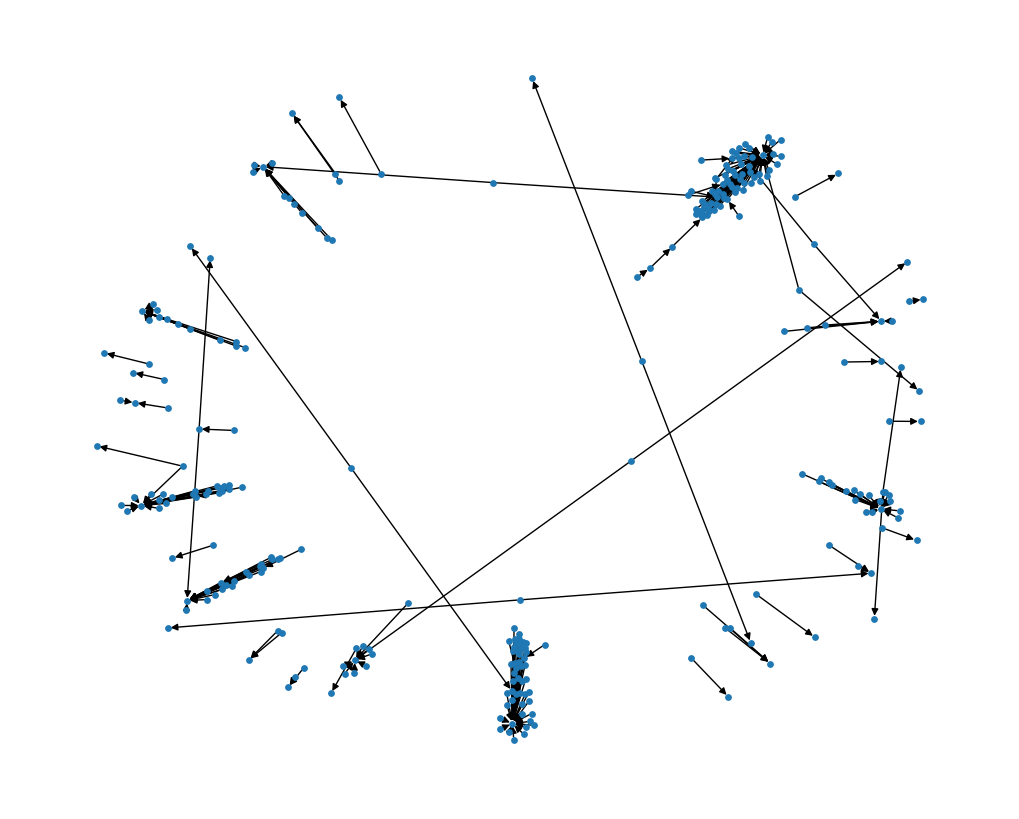

In [60]:
# Filter illicit transactions for time step 32
ilicit_ids = df.loc[(df['Timestep'] == 13) & (df['class'] == '1'), 'txId']
ilicit_edges = df_edgelist.loc[df_edgelist['txId1'].isin(ilicit_ids)]

# Create a directed graph from the DataFrame
graph = nx.from_pandas_edgelist(ilicit_edges, source='txId1', target='txId2', create_using=nx.DiGraph())

# Layout for the graph
pos = nx.spring_layout(graph)

# Set the figure size directly in NetworkX
plt.figure(figsize=(10, 8))

# Draw the graph with smaller node size
nx.draw(graph, with_labels=False, pos=pos, node_size=15)

# Show the plot
plt.show()

## 3. Feature engineering

In [67]:
# Rename the 'class' column to 'class_'
df.rename(columns={'class': 'class_'}, inplace=True)

In [83]:
class TrainTestSplitter(object):
    '''Class to perform the split of the data into train, test, and validation.
    '''
    def __init__(self, train_frac=0.8, validation_frac=0.2, seed=1234):
        self.train_frac = train_frac
        self.validation_frac = validation_frac
        self.seed = seed
    
    def calculate_statistics(self):
        statistics = {}
        for i in ['train_set', 'test_set', 'validation_set']:
            split_stats = {}
            default_count = (getattr(self, i).groupby('class_').size().reset_index())
            split_stats['N_Ilicit'] = (default_count.loc[lambda x: x.class_ ==1, 0].iloc[0])
            split_stats['percentage_total_Ilicit'] = split_stats['N_Ilicit']/self.total_n_defaults * 100
            split_stats['N_licit'] = default_count.loc[lambda x: x.class_ == 0, 0].iloc[0]
            split_stats['percentage_total_Licit'] = split_stats['N_licit']/self.total_n_not_defaults * 100
            split_stats['N_unknown'] = (default_count.loc[lambda x: x.class_ ==1, 0].iloc[0])
            split_stats['percentage_total_unknown'] = split_stats['N_unknown']/self.total_n_defaults * 100
            statistics[i] = split_stats
        self.split_statistics = statistics

    def split_train_test(self, df):
        print("Generating the train/validation/test splits...")
        self.total_n_ilicit = df.loc[lambda x: x.class_ == 1].shape[0]
        self.total_n_licit = df.loc[lambda x: x.class_ == 2].shape[0]
        self.total_n_unknown = df.loc[lambda x: x.class_ == 3].shape[0]
        self.train_set = df.sample(frac=self.train_frac, random_state=self.seed)
        self.test_set = df.loc[lambda x: ~x.txId.isin(self.train_set.txId)].reset_index(drop=True)
        self.validation_set = self.train_set.sample(frac=self.validation_frac).reset_index(drop=True)
        self.train_set = self.train_set.loc[lambda x: ~x.txId.isin(self.validation_set.txId)].reset_index(drop=True)
        print("calculating the statistics...")
        self.calculate_statistics()
        print("split completed")

In [84]:
# create a fitting_splits object that will hold the train, validation, and test data
fitting_splits = TrainTestSplitter()

In [85]:
fitting_splits.split_train_test(df)

Generating the train/validation/test splits...
calculating the statistics...


IndexError: single positional indexer is out-of-bounds